In [2]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pybounds import Simulator, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline

/usr/local/lib/python3.10/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.10/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} = 
f(\mathbf{x}) = \begin{bmatrix} 
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} = 
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [3]:
state_names = ['x',  # x position [m]
               'y',  # y position [m]
               'v_para',  # parallel velocity [m/s]
               'v_perp',  # perpendicular velocity [m/s]
               'phi', # heading [rad]
               'phi_dot',  # angular velocity [rad/s]
               'w',  # ambient wind speed [m/s]
               'zeta',  # ambient wind angle [rad]
               ]

input_names = ['u_para',  # translational speed [m/s]
               'u_phi'  # angular velocity [rad/s]
               ] 
def f(X, U):
    # States
    x, y, v_para, v_perp, phi, phi_dot, w, zeta = X
    
    # Inputs
    u_para, u_phi = U
    
    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    
    # Acceleration
    
    # Angular acceleration

    # Other dynamics
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)
    z_dot = 0*x
    w_dot = 0*x
    zeta_dot = 0*x

    # Package and return xdot
    x_dot = [x_dot, y_dot, z_dot, phi_dot, w_dot, zeta_dot]

    return x_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [4]:
measurement_names = ['phi', 'psi', 'gamma', 'a', 'g', 'r']
def h(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi = U
    
    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    a = np.sqrt(a_para ** 2 + a_perp ** 2)
    gamma = np.arctan2(a_perp, a_para)  # air velocity angle
    
    # Course direction in fly reference frame
    g = np.sqrt(v_para ** 2 + v_perp ** 2)
    psi = np.arctan2(v_perp, v_para)
    
    # Optic flow
    r = g / z
    
    # Unwrap angles
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
            gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, psi, gamma, a, g, r]

    # Return measurement
    return Y


## Set time-step

In [5]:
dt = 0.01  # [s]

# Create simulator object

In [6]:
simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

# Can also set the number of state (n) & inputs (m0 instead of state & input names)
# simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Set up model predictive control

In [7]:
# Parameters in SI units
m = 0.25e-6  # [kg]
I = 5.2e-13  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.02369
# I = 4.971e-12  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.038778
C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
C_perp = C_para  # assume same as C_para

# Scale Parameters
m = m * 1e6  # [mg]
I = I * 1e6 * (1e3) ** 2  # [mg*mm/s^2 * mm*s^2]
C_phi = C_phi * 1e6 * (1e3) ** 2  # [mg*mm/s^2 *m*s]
C_para = C_para * 1e6  # [mg/s]
C_perp = C_perp * 1e6  # [mg/s]

In [8]:
# Define the set-point(s) to follow
tsim = np.arange(0, 0.4, step=dt)

setpoint = {'x': 0.0 * np.ones_like(tsim),
            'y': 0.0 * np.ones_like(tsim),
            'z': 0.2 * np.ones_like(tsim),
            'v_para': 0.3 * np.ones_like(tsim) + 0.01*tsim,
            'v_perp': 0.01 * np.ones_like(tsim) + 0.01*tsim,
            'phi': (np.pi/4) * np.ones_like(tsim),
            'phi_dot': 0.0*np.ones_like(tsim),
            'w': 0.4 * np.ones_like(tsim),
            'zeta': (np.pi) * np.ones_like(tsim),
            'm': m * np.ones_like(tsim),
            'I': I * np.ones_like(tsim),
            'C_para': C_para * np.ones_like(tsim),
            'C_perp': C_perp * np.ones_like(tsim),
            'C_phi': C_phi * np.ones_like(tsim),
            'km1': 1.0 * np.ones_like(tsim),
            'km2': 0.0 * np.ones_like(tsim),
            'km3': 1.0 * np.ones_like(tsim),
            'km4': 1.0 * np.ones_like(tsim),
            }

# Add a turn
setpoint['phi'][20:] = setpoint['phi'][20] - np.pi/2

# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [9]:
# Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 + 
        (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
        (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2)

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [10]:
# Set input penalty: make this small for accurate state following
simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6)

# Run model predictive control

In [11]:
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 1.4112536907196045


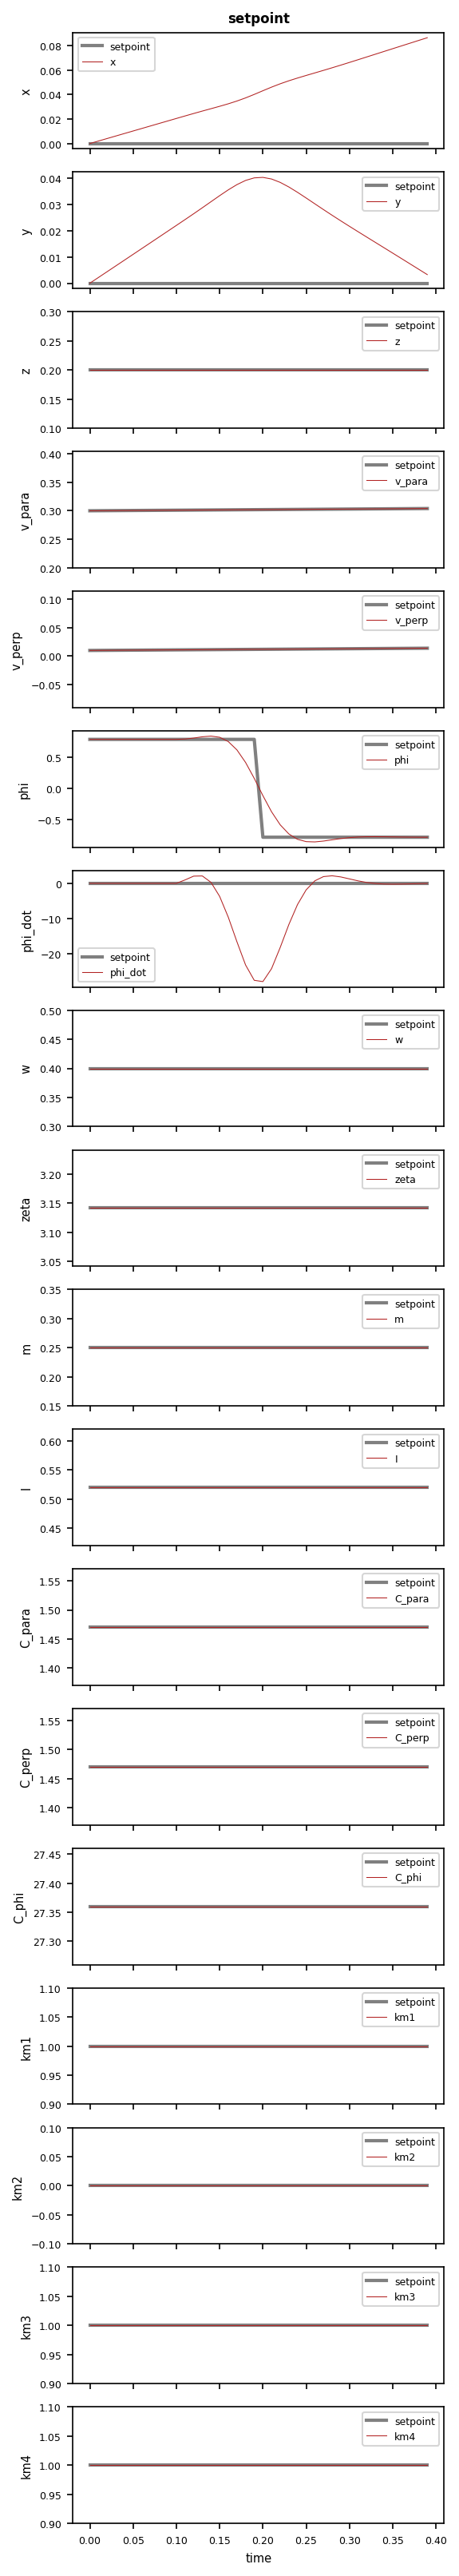

In [12]:
# Plot set-point tracking
# Note that the cost function defined above & the controllability of each state will determine if a set-point is tracked or not
simulator.plot('setpoint')

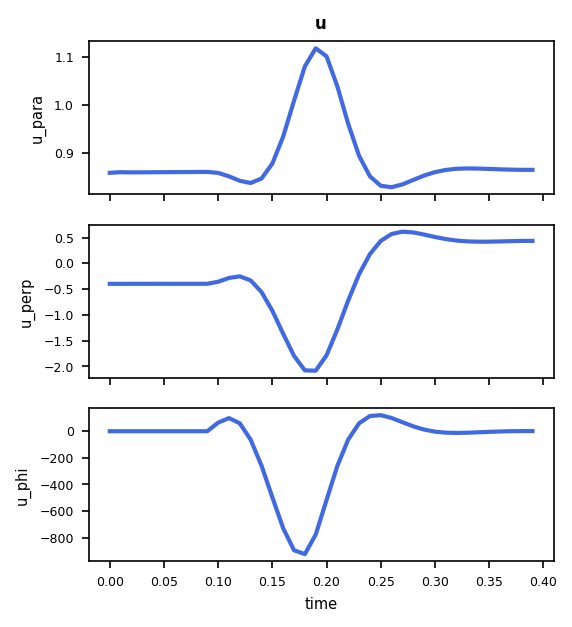

In [42]:
# Plot inputs
simulator.plot('u')

# Re-run simulator with MPC inputs
This step isn't required, but it shows how the closed-loop MOC inputs can be replayed in open-loop to get the same state trajectory

In [13]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=False, u=u_sim, return_full_output=True)

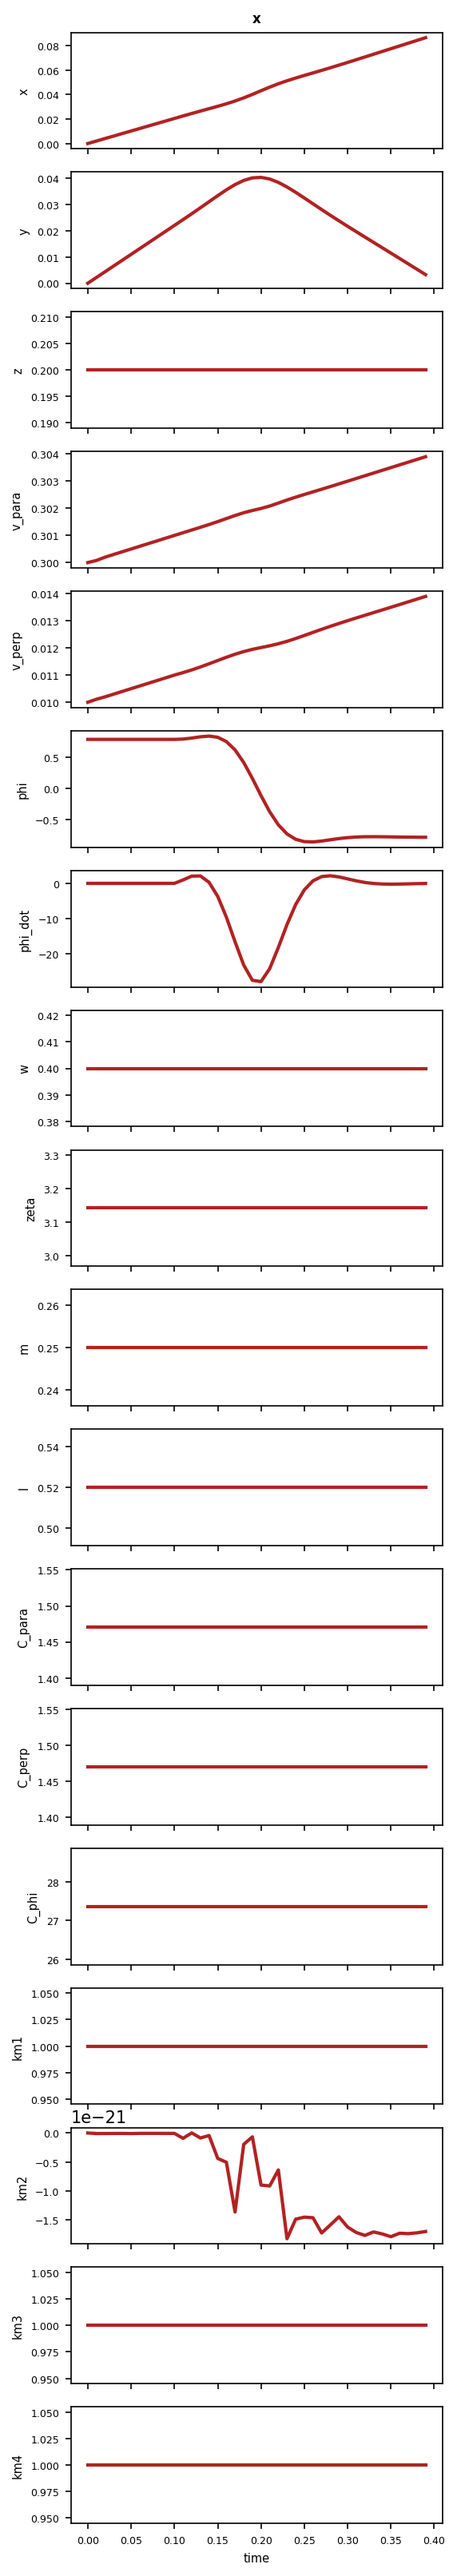

In [14]:
# Plot state
simulator.plot('x')

# Observability

## Construct observability matrix in sliding windows

In [15]:
w = 4  # window size, set to None to use entire time-series as one window

In [16]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 4.091982364654541


In [17]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [18]:
n_window = len(O_sliding)
print(n_window, 'windows')

37 windows


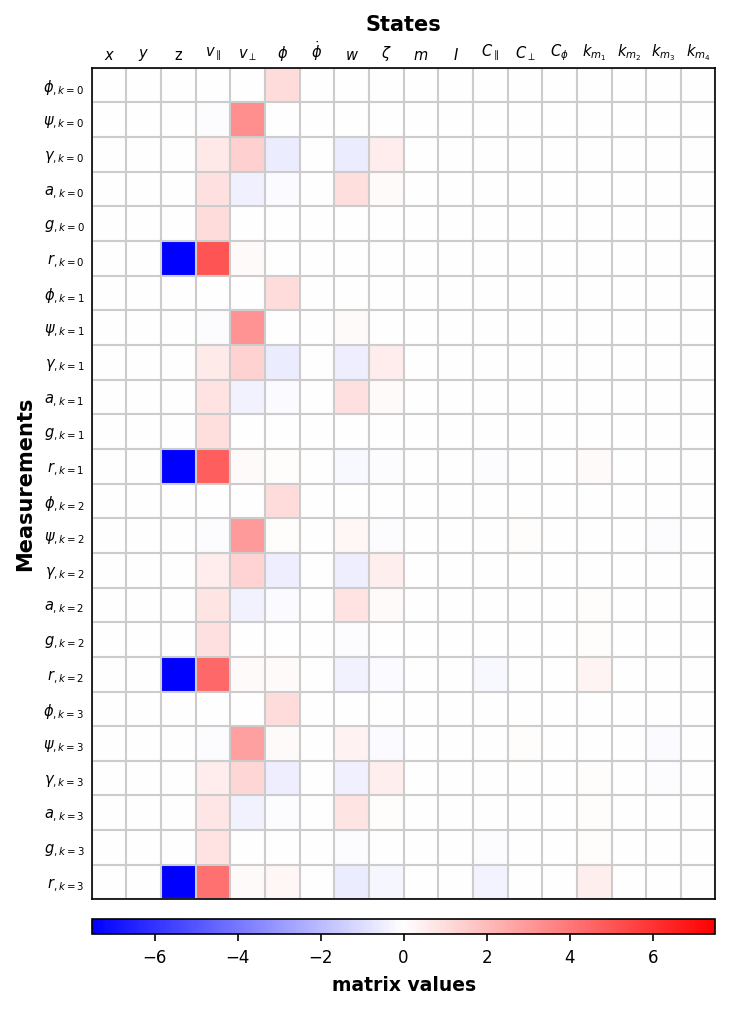

In [19]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [20]:
# Set each sensor noise level
sensor_noise = {'phi': 0.1, 'psi': 0.1, 'gamma': 0.1, 'a': 0.1, 'g': 0.1, 'r': 0.1}

In [21]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=None, sensor_noise_dict=sensor_noise, lam=1e-6)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [22]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

x             y             z     v_para     v_perp  \
x        1.000000e+06 -3.605509e-04 -3.627745e-08  -0.000352  -0.000512   
y       -3.605563e-04  1.000000e+06 -1.242231e-07  -0.000402  -0.000586   
z       -3.659364e-08 -1.238818e-07  1.153122e-02   0.016632   0.000556   
v_para  -3.515582e-04 -4.023486e-04  1.663168e-02   0.027136   0.000438   
v_perp  -5.124051e-04 -5.863144e-04  5.558432e-04   0.000438   0.006263   
phi     -9.122320e-04 -1.044099e-03 -7.297960e-06   0.000366  -0.000256   
phi_dot  2.091371e-01  2.393756e-01  7.102369e-04  -0.021922   0.344984   
w        1.313142e-07  2.546321e-07 -1.136797e-02  -0.017107   0.001074   
zeta     1.719340e-07  2.230660e-07 -3.040989e-02  -0.045487  -0.005370   
m       -6.839435e+00 -7.823925e+00 -9.498758e-03 -13.131815   5.805345   
I        1.540351e-03  1.762035e-03 -1.599841e-06   0.000334   0.004336   
C_para   1.271406e+00  1.454387e+00  9.336604e-04   1.810426   0.769389   
C_perp  -4.965737e-01 -5.680112e-01  2.150500e-04  -0.345309  -1.480347   
C_phi    4.520404e-05  5.173332e-05 -6.548517e-08   0.000008   0.000138   
km1      8.232610e-01  9.417455e-01  6.762438e-04   1.038738   0.591651   
km2     -4.836343e+00 -5.534170e+00  5.359212e-03  -0.889697 -14.346452   
km3     -2.528620e-01 -2.892578e-01  9.170656e-06   0.089632  -0.997460   
km4     -2.036944e-03 -2.330742e-03  2.397931e-06  -0.000380  -0.006036   

               phi       phi_dot             w          zeta              m  \
x        -0.000912      0.209138  1.284092e-07  1.699326e-07      -6.839437   
y        -0.001044      0.239375  2.546574e-07  2.236017e-07      -7.823990   
z        -0.000007      0.000710 -1.136797e-02 -3.040989e-02      -0.009499   
v_para    0.000366     -0.021922 -1.710744e-02 -4.548733e-02     -13.131815   
v_perp   -0.000256      0.344984  1.073843e-03 -5.370316e-03       5.805345   
phi       0.067488     -5.119045  8.277804e-06  2.502733e-02       2.885848   
phi_dot  -5.119045    901.897346 -8.114017e-04 -2.644488e-03    -734.445214   
w         0.000008     -0.000811  3.615692e-02  4.009973e-02       0.014179   
zeta      0.025027     -0.002644  4.009973e-02  1.903352e-01       0.030145   
m         2.885848   -734.445214  1.417887e-02  3.014516e-02  395544.454340   
I        -0.007338     13.200928  1.811505e-06  5.720030e-06     -17.320715   
C_para    1.558201   -374.599676 -1.707575e-02 -2.685457e-02   62628.531805   
C_perp   -2.110367    476.335178 -2.282473e-02  2.189185e-02   10052.317975   
C_phi    -0.000128      0.087686  1.407435e-07  1.391371e-06      -0.327103   
km1       1.089313   -263.932958  2.227819e-02  3.241619e-02   47162.835003   
km2      13.505112 -14574.452839 -5.815839e-03 -2.078422e-02   18478.176991   
km3      -0.998766    297.932925  3.285546e-02 -3.265910e-02   -2932.571088   
km4       0.007321     -9.260895 -2.706610e-06 -9.413990e-06      17.942522   

                     I         C_para         C_perp         C_phi  \
x             0.001540       1.273731      -0.496560  4.520418e-05   
y             0.001762       1.452360      -0.568050  5.173357e-05   
z            -0.000002       0.000934       0.000215 -6.548517e-08   
v_para        0.000334       1.810426      -0.345309  7.534483e-06   
v_perp        0.004336       0.769389      -1.480347  1.382150e-04   
phi          -0.007338       1.558201      -2.110367 -1.280769e-04   
phi_dot      13.200928    -374.599676     476.335178  8.768605e-02   
w             0.000002      -0.017076      -0.022825  1.407435e-07   
zeta          0.000006      -0.026855       0.021892  1.391371e-06   
m           -17.320715   62628.531805   10052.317975 -3.271035e-01   
I        999999.960140      -3.132378       4.973520 -1.029015e-03   
C_para       -3.132378  675755.726183    1775.642301 -5.276844e-02   
C_perp        4.973520    1775.642308  679599.192663  8.645035e-02   
C_phi        -0.001029      -0.052768       0.086450  1.000000e+06   
km1          -2.324471  458893.565978    1

## Compute Fisher information matrix & inverse for each sliding window

In [23]:
# Choose sensors to use from O
o_sensors = ['phi', 'psi', 'gamma']

# Chose states to use from O
o_states = ['v_para', 'v_perp', 'phi', 'phi_dot', 'w', 'zeta', 'z', 'm', 'I', 'C_para', 'C_perp', 'C_phi']

# Choose time-steps to use from O
window_size = 4
o_time_steps = np.arange(0, window_size, step=1)

In [24]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=None, sensor_noise_dict=sensor_noise,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [25]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [26]:
EV_aligned

time  time_initial         v_para      v_perp       phi       phi_dot  \
0   0.00           NaN            NaN         NaN       NaN           NaN   
1   0.01           NaN            NaN         NaN       NaN           NaN   
2   0.02          0.00  226328.031317  251.555252  0.078679    691.277080   
3   0.03          0.01  222914.830504  252.797080  0.078740    692.075219   
4   0.04          0.02  227785.374024  262.855334  0.078529    689.356179   
5   0.05          0.03  227744.841005  267.807716  0.078530    689.356946   
6   0.06          0.04  227672.793699  272.766633  0.078531    689.364515   
7   0.07          0.05  227607.306008  277.773645  0.078531    689.369345   
8   0.08          0.06  227538.437750  282.817025  0.078519    689.223286   
9   0.09          0.07  227457.480128  287.884903  0.078518    689.207678   
10  0.10          0.08   28144.138206   36.192192  0.088102   1206.974188   
11  0.11          0.09   20815.218226   27.273879  0.093871   1903.122119   
12  0.12          0.10   20927.701994   27.901869  0.098254   5577.013640   
13  0.13          0.11   26604.120999   36.046810  0.081209   5401.111918   
14  0.14          0.12   19776.100483   27.320871  0.092603   2419.848965   
15  0.15          0.13   19597.560570   27.573411  0.094833   3563.091002   
16  0.16          0.14   19589.069559   28.110200  0.095915   5008.456995   
17  0.17          0.15   19602.369922   28.704259  0.096486   6613.281414   
18  0.18          0.16   19618.770852   29.303909  0.096543   7632.179759   
19  0.19          0.17   19635.764810   29.873119  0.096170   7698.964739   
20  0.20          0.18   19649.024190   30.371972  0.095687   7663.428566   
21  0.21          0.19   19657.918342   30.784849  0.095402   7601.448862   
22  0.22          0.20   19673.441773   31.140271  0.095478   7007.503189   
23  0.23          0.21   19709.172615   31.513420  0.095971   6429.301996   
24  0.24          0.22   19757.038877   31.958205  0.096734   6287.662655   
25  0.25          0.23   19801.281700   32.479524  0.097469   6594.813875   
26  0.26          0.24   19859.929960   33.105108  0.098113   7325.363629   
27  0.27          0.25   20049.277453   34.004109  0.098838   9046.406520   
28  0.28          0.26   21562.727054   37.203827  0.098061  16491.226581   
29  0.29          0.27   26312.846569   46.069535  0.090813   2948.984748   
30  0.30          0.28   22968.786758   41.089113  0.095811   3388.184374   
31  0.31          0.29   22488.359391   40.883631  0.096726   4375.798806   
32  0.32          0.30   23831.704923   44.005226  0.097225   5136.586068   
33  0.33          0.31   28486.537489   53.405615  0.097541   5930.361295   
34  0.34          0.32   46046.752611   87.583180  0.097394   7083.514959   
35  0.35          0.33  120377.444550  232.010002  0.093659   9554.554650   
36  0.36          0.34  224760.071798  438.677383  0.082988    898.740747   
37  0.37          0.35  157526.736685  311.350039  0.090374   2290.204911   
38  0.38          0.36  135577.040889  271.670290  0.091927   3336.902618   
39  0.39           NaN            NaN         NaN       NaN           NaN   

                w           zeta          z              m              I  \
0             NaN            NaN        NaN            NaN            NaN   
1             NaN            NaN        NaN            NaN            NaN   
2   130026.072450  685804.536488  1000000.0  873715.384342  999999.942860   
3   128665.262096  675456.192940  1000000.0  942820.935880  999999.979656   
4   129898.821225  689502.825246  1000000.0  998531.241812  999999.914336   
5   129816.912740  689768.741764  1000000.0  998536.605547  999999.885662   
6   129725.437238  689941.943358  1000000.0  998535.706532  999999.898171   
7   129636.191419  690134.141891  1000000.0  998534.975128  999999.930152   
8   129545.839167  690315.419420  1000000.0  998534.314254  999999.962582   
9   129451.610952  690459.724384  1000000.0  998532.949511  999999.985795   

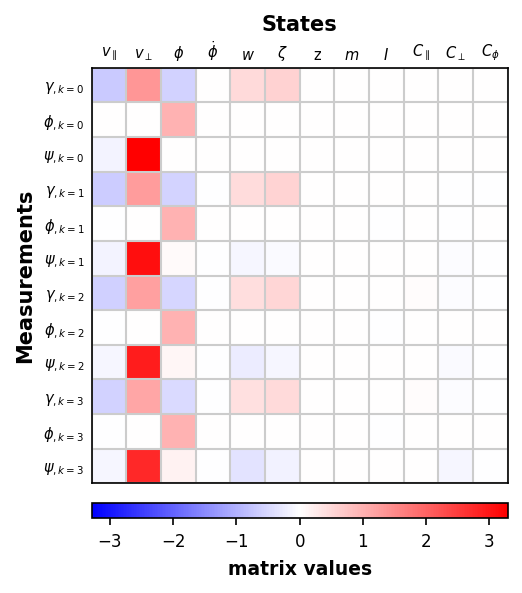

In [27]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[-1].O)
OI.plot()

# Plot error variance as color on state time-series

In [28]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipykernel_646533/1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


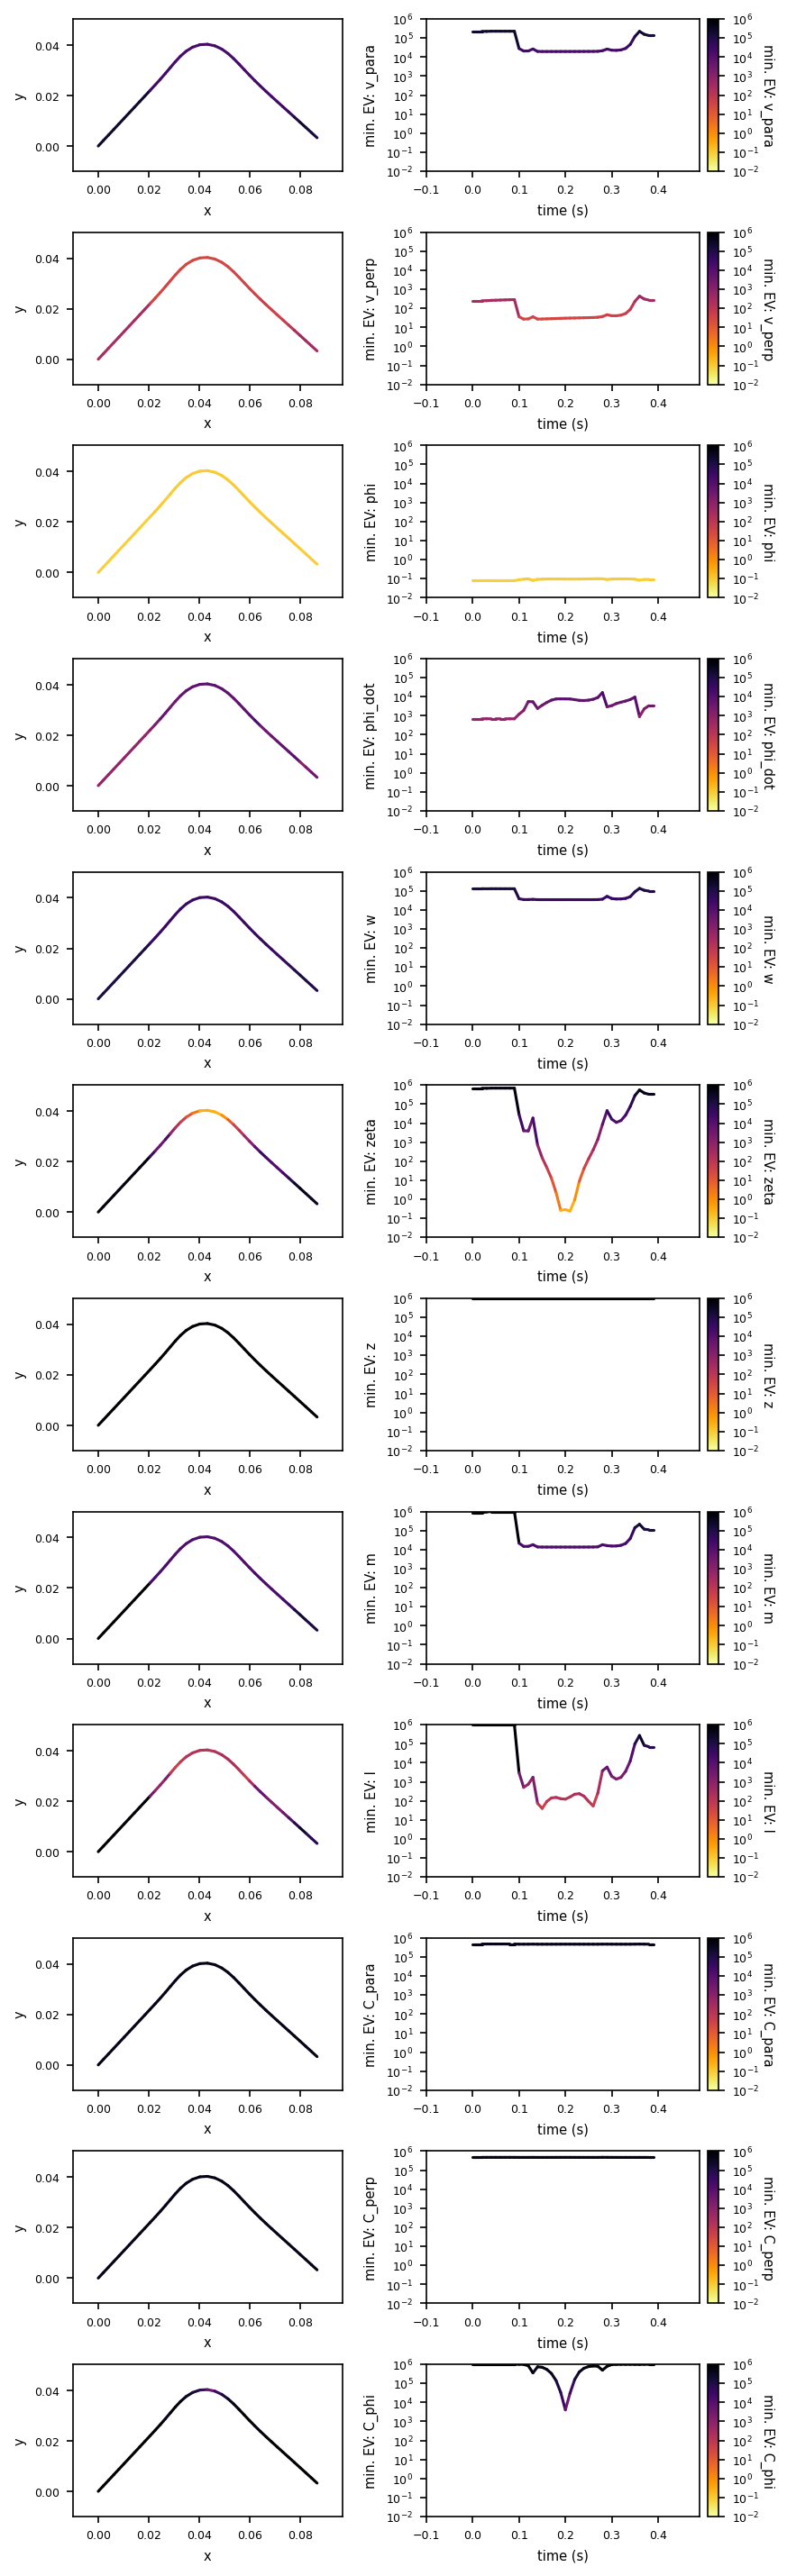

In [29]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)
    
    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)
    
# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()